# Understanding the Causes

## Looking at underfitting

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(51)

x = np.array(range(1, 50))
vary = (np.random.random(len(x))) / 3
y = np.sin(x * np.pi / 50.) + vary

 
0.0009757 x + 0.7852


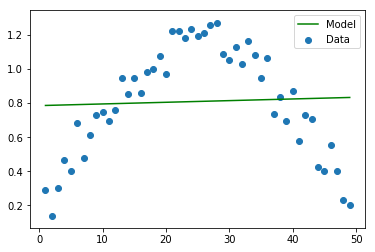

In [2]:
plt.scatter(x, y)

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
print(p)

plt.plot(x, p(x), 'g-')
plt.legend(['Model', 'Data'])
plt.show()

## Looking at overfitting

          18             17            16             15             14
1.44e-22 x  - 6.054e-20 x  + 1.17e-17 x  - 1.379e-15 x  + 1.109e-13 x 
              13             12             11             10
 - 6.465e-12 x  + 2.826e-10 x  - 9.461e-09 x  + 2.458e-07 x 
             9             8             7           6           5
 - 4.99e-06 x + 7.923e-05 x - 0.0009799 x + 0.00935 x - 0.06763 x
           4         3         2
 + 0.3602 x - 1.346 x + 3.247 x - 4.253 x + 2.339


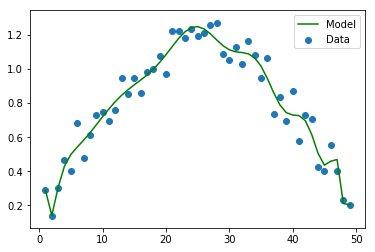

In [3]:
plt.scatter(x, y)

z = np.polyfit(x, y, 18)
p = np.poly1d(z)
print(p)

plt.plot(x, p(x), 'g-')
plt.legend(['Model', 'Data'])
plt.show()

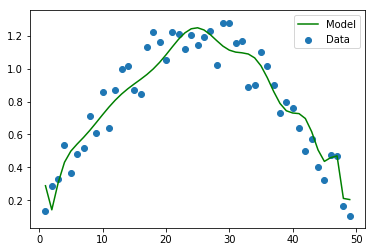

In [4]:
np.random.seed(22)

vary = (np.random.random(len(x))) / 3
y = np.sin(x * np.pi / 50.) + vary

plt.scatter(x, y)

plt.plot(x, p(x), 'g-')
plt.legend(['Model', 'Data'])
plt.show()

## Plotting learning curves for insights

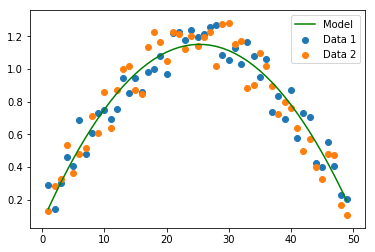

In [5]:
np.random.seed(51)

x = np.array(range(1, 50))
vary = (np.random.random(len(x))) / 3
y1 = np.sin(x * np.pi / 50.) + vary
plt.scatter(x, y1)

z = np.polyfit(x, y1, 2)
p = np.poly1d(z)
plt.plot(x, p(x), 'g-')

np.random.seed(22)
vary = (np.random.random(len(x))) / 3
y2 = np.sin(x * np.pi / 50.) + vary
plt.scatter(x, y2)

plt.legend(['Model', 'Data 1', 'Data 2'])
plt.show()

# Guessing the Right Features

## Selecting Variables Like a Pro

### Selecting by univariate measures

In [6]:
from sklearn.datasets import load_boston
from sklearn.preprocessing import scale
from sklearn.metrics import mean_squared_error

boston = load_boston()
X = scale(boston.data)
y = boston.target

In [7]:
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_regression
Selector_f = SelectPercentile(f_regression, percentile=25)
Selector_f.fit(X, y)
for n,s in zip(boston.feature_names,Selector_f.scores_):
    print('F-score: %3.2f\t for feature %s ' % (s,n))

F-score: 89.49	 for feature CRIM 
F-score: 75.26	 for feature ZN 
F-score: 153.95	 for feature INDUS 
F-score: 15.97	 for feature CHAS 
F-score: 112.59	 for feature NOX 
F-score: 471.85	 for feature RM 
F-score: 83.48	 for feature AGE 
F-score: 33.58	 for feature DIS 
F-score: 85.91	 for feature RAD 
F-score: 141.76	 for feature TAX 
F-score: 175.11	 for feature PTRATIO 
F-score: 63.05	 for feature B 
F-score: 601.62	 for feature LSTAT 


### Using a greedy search

In [8]:
from sklearn.linear_model import LinearRegression
regression = LinearRegression()
regression.fit(X,y)
print('Mean squared error: %.2f' % mean_squared_error(
    y_true=y, y_pred=regression.predict(X)))

Mean squared error: 21.89


In [9]:
from sklearn.feature_selection import RFECV
selector = RFECV(estimator=regression, 
                 cv=10, 
                 scoring='neg_mean_squared_error')
selector.fit(X, y)
print("Optimal number of features : %d" 
      % selector.n_features_)

Optimal number of features : 11


In [10]:
print(boston.feature_names[selector.support_])

['CRIM' 'ZN' 'CHAS' 'NOX' 'RM' 'DIS' 'RAD' 'TAX' 'PTRATIO' 'B' 'LSTAT']


## Using Nonlinear Transformations

### Doing variable transformations

In [11]:
import random
from random import shuffle

random.seed(0) # Creates a replicable shuffling
new_index = list(range(boston.data.shape[0]))
shuffle(new_index) # shuffling the index
X, y = boston.data[new_index], boston.target[new_index]
print(X.shape, y.shape, boston.feature_names)

(506, 13) (506,) ['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


In [12]:
import pandas as pd
df = pd.DataFrame(X,columns=boston.feature_names)
df['target'] = y

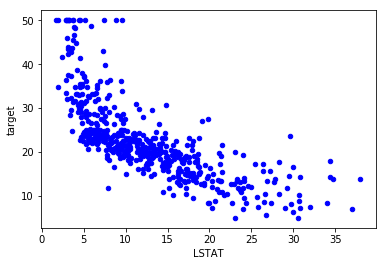

In [13]:
ax = df.plot(kind='scatter', x='LSTAT', y='target', c='b')

In [14]:
single_variable = df['LSTAT'].values.reshape(-1, 1)
F, pval = f_regression(single_variable, y)
print('F score for the original feature %.1f' % F)
F, pval = f_regression(np.log(single_variable),y)
print('F score for the transformed feature %.1f' % F)

F score for the original feature 601.6
F score for the transformed feature 1000.2


### Creating interactions between variables

In [15]:
from sklearn.model_selection import cross_val_score, KFold
regression = LinearRegression(normalize=True)
crossvalidation = KFold(n_splits=10, shuffle=True,
                        random_state=1)

In [16]:
df = pd.DataFrame(X,columns=boston.feature_names)
baseline = np.mean(cross_val_score(regression, df, y, 
                                   scoring='r2', 
                                   cv=crossvalidation))
interactions = list()
for var_A in boston.feature_names:
    for var_B in boston.feature_names:
        if var_A > var_B:
            df['interaction'] = df[var_A] * df[var_B]
            cv = cross_val_score(regression, df, y, 
                                 scoring='r2', 
                                 cv=crossvalidation)
            score = round(np.mean(cv), 3)
            if score > baseline:
                interactions.append((var_A, var_B, score))
print('Baseline R2: %.3f' % baseline)
print('Top 10 interactions: %s' % sorted(interactions, 
                                    key=lambda x :x[2], 
                                    reverse=True)[:10])

Baseline R2: 0.716
Top 10 interactions: [('RM', 'LSTAT', 0.79), ('TAX', 'RM', 0.782), ('RM', 'RAD', 0.778), ('RM', 'PTRATIO', 0.766), ('RM', 'INDUS', 0.76), ('RM', 'NOX', 0.747), ('RM', 'AGE', 0.742), ('RM', 'B', 0.738), ('RM', 'DIS', 0.736), ('ZN', 'RM', 0.73)]


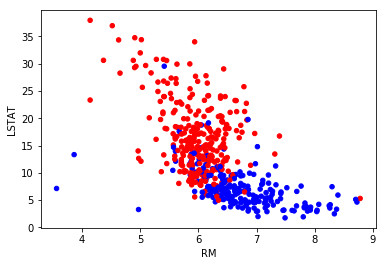

In [17]:
colors = ['b' if v > np.mean(y) else 'r' for v in y]
scatter = df.plot(kind='scatter', x='RM', y='LSTAT', 
                  c=colors) 

In [18]:
polyX = pd.DataFrame(X,columns=boston.feature_names)
cv = cross_val_score(regression, polyX, y, 
                     scoring='neg_mean_squared_error', 
                     cv=crossvalidation)
baseline = np.mean(cv)
improvements = [baseline]
for var_A in boston.feature_names: 
    polyX[var_A+'^2'] = polyX[var_A]**2
    cv = cross_val_score(regression, polyX, y, 
                         scoring='neg_mean_squared_error', 
                         cv=crossvalidation)
    improvements.append(np.mean(cv))
    for var_B in boston.feature_names:
        if var_A > var_B:
            poly_var = var_A + '*' + var_B
            polyX[poly_var] = polyX[var_A] * polyX[var_B]
            cv = cross_val_score(regression, polyX, y, 
                         scoring='neg_mean_squared_error', 
                         cv=crossvalidation)
            improvements.append(np.mean(cv))

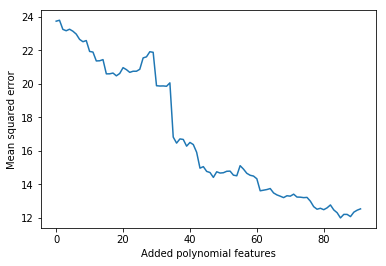

In [19]:
plt.figure() 
plt.plot(range(0,92),np.abs(improvements),'-')
plt.xlabel('Added polynomial features')
plt.ylabel('Mean squared error')
plt.show()

In [20]:
print('New shape of X:', np.shape(polyX))
crossvalidation = KFold(n_splits=10, shuffle=True, 
                        random_state=1)
cv = cross_val_score(regression, polyX, y, 
                     scoring='neg_mean_squared_error', 
                     cv=crossvalidation)
print('Mean squared error: %.3f' % abs(np.mean(cv)))

New shape of X: (506, 104)
Mean squared error: 12.529


## Regularizing linear models

### Relying on Ridge regression (L2)

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
ridge = Ridge(normalize=True)
search_grid = {'alpha':np.logspace(-5,2,8)}
search = GridSearchCV(estimator=ridge, 
                      param_grid=search_grid, 
                      scoring='neg_mean_squared_error', 
                      refit=True, cv=10, iid=False)
search.fit(polyX,y)
print('Best parameters: %s' % search.best_params_)
score = abs(search.best_score_)
print('CV MSE of best parameters: %.3f' % score)

Best parameters: {'alpha': 0.001}
CV MSE of best parameters: 11.641


### Using the Lasso (L1)

In [22]:
from sklearn.linear_model import Lasso
lasso = Lasso(normalize=True,tol=0.05, selection='random')
search_grid = {'alpha':np.logspace(-2,3,8)}
search = GridSearchCV(estimator=lasso, 
                      param_grid=search_grid, 
                      scoring='neg_mean_squared_error', 
                      refit=True, cv=10, iid=False)
search.fit(polyX,y)
print('Best parameters: %s' % search.best_params_)
score = abs(search.best_score_)
print('CV MSE of best parameters: %.3f' % score)

Best parameters: {'alpha': 0.01}
CV MSE of best parameters: 20.406


### Leveraging regularization

In [23]:
lasso = Lasso(normalize=True, alpha=0.01)
lasso.fit(polyX,y)
print(polyX.columns[np.abs(lasso.coef_)>0.0001].values)

['CRIM*CHAS' 'ZN*CRIM' 'ZN*CHAS' 'INDUS*DIS' 'CHAS*B' 'NOX^2' 'NOX*DIS'
 'RM^2' 'RM*CRIM' 'RM*NOX' 'RM*PTRATIO' 'RM*B' 'RM*LSTAT' 'RAD*B'
 'TAX*DIS' 'PTRATIO*NOX' 'LSTAT^2']


### Combining L1 & L2: Elasticnet

In [24]:
from sklearn.linear_model import ElasticNet
elastic = ElasticNet(normalize=True, selection='random')
search_grid = {'alpha':np.logspace(-4,3,8), 
               'l1_ratio': [0.10 ,0.25, 0.5, 0.75]}
search = GridSearchCV(estimator=elastic, 
                      param_grid=search_grid, 
                      scoring='neg_mean_squared_error', 
                      refit=True, cv=10, iid=False)
search.fit(polyX,y)
print('Best parameters: %s' % search.best_params_)
score = abs(search.best_score_)
print('CV MSE of best parameters: %.3f' % score)

Best parameters: {'alpha': 0.0001, 'l1_ratio': 0.75}
CV MSE of best parameters: 12.586
